In [128]:
import os
import gc
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score


## Data

#### (i) Features

In [2]:
columns = [
    # Cast 'page' as 'Float32' data type
    pl.col('page').cast(pl.Float32),
        (   # Calculates the difference over [session_id, level], fills null values with 0, clips the valus between 0 and 1e9
            (pl.col('elapsed_time') - pl.col('elapsed_time').shift(1))
            .fill_null(0).clip(0, 1e9).over(['session_id', 'level'])
            .alias('elapsed_time_diff')
        ),
        (   # Calculates the absolute difference
            (pl.col('screen_coor_x') - pl.col('screen_coor_x').shift(1))
            .abs().over(['session_id', 'level'])
        ),
        (   # Calculates the absolute difference
            (pl.col('screen_coor_y') - pl.col('screen_coor_y').shift(1))
            .abs().over(['session_id', 'level'])
        ),
    # Fills null values
    pl.col('fqid').fill_null('fqid_None'),
    pl.col('text_fqid').fill_null('text_fqid_None')
    ]

In [3]:
df = (pl.read_csv('train.csv').with_columns(columns))

In [40]:
# df1
df1 = df.filter(pl.col('level_group') == '0-4')

In [36]:
# df2
df2 = df.filter(pl.col('level_group') == '5-12')

In [37]:
# df3
df3 = df.filter(pl.col('level_group') == '13-22')

#### (ii) Target

In [123]:
labels_df = pd.read_csv('train_labels.csv')
labels_df['session'] = labels_df['session_id'].apply(lambda x: int(x.split('_')[0]))
labels_df['q'] = labels_df['session_id'].apply(lambda x : int(x.split('_q')[1]))
labels_df.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


## Feature Engineering

In [74]:
# CATs
CATs = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']

event_name_list = df['event_name'].unique().to_list()
name_list = df['name'].unique().to_list()
fqid_list = df['fqid'].unique().to_list()
fqid_list.remove('fqid_None')
text_list = df['text_fqid'].unique().to_list()
text_list.remove('text_fqid_None')
room_fqid_list = df['room_fqid'].unique().to_list()
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

# NUMs
NUMs = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'elapsed_time_diff']

# LEVELs
levels_list = list(np.arange(1, 23))
level_groups_list = ['0-4', '5-12', '13-22']

In [75]:
# Create Features
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        # Count the number of index
        pl.col('index').count().alias(f"session_number_{feature_suffix}"),

        # Count the number of occurrences of each element in DIALOGS in the 'text' column
        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],

        # Calculate the mean/std/max/sum/median of 'elapsed_time_diff' for each element in DIALOGS in the 'text' column
        *[pl.col('elapsed_time_diff').filter((pl.col('text').str.contains(c))).mean().alias(f"word_mean_{c}") for c in DIALOGS],
        *[pl.col('elapsed_time_diff').filter((pl.col('text').str.contains(c))).std().alias(f"word_std_{c}") for c in DIALOGS],
        *[pl.col('elapsed_time_diff').filter((pl.col('text').str.contains(c))).max().alias(f"word_max_{c}") for c in DIALOGS],
        *[pl.col('elapsed_time_diff').filter((pl.col('text').str.contains(c))).sum().alias(f"word_sum_{c}") for c in DIALOGS],
        *[pl.col('elapsed_time_diff').filter((pl.col('text').str.contains(c))).median().alias(f"word_median_{c}") for c in DIALOGS],

        # Count the number of unique values in each column in CATS
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATs],

        # Calculate the mean/std/min/max/median of each column in NUMS
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMs],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMs],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMs],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMs],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMs],

        # fqid
        # Count the number of occurrences of each element in fqid_lists in the 'fqid' column
        # Calculate the mean/std/max/sum/median of 'elapsed_time_diff' for each element in CATS
        *[pl.col('fqid').filter(pl.col('fqid') == c).count().alias(f"{c}_fqid_counts{feature_suffix}") for c in fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('fqid') == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in fqid_list],

        # text
        *[pl.col('text_fqid').filter(pl.col('text_fqid') == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in text_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('text_fqid') == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in text_list],

        # room_fqid
        *[pl.col('room_fqid').filter(pl.col('room_fqid') == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}") for c in room_fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in room_fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in room_fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in room_fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in room_fqid_list],
        *[pl.col('elapsed_time_diff').filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in room_fqid_list],

        # event_name
        *[pl.col('event_name').filter(pl.col('event_name') == c).count().alias(f"{c}_event_name_counts{feature_suffix}") for c in event_name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in event_name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in event_name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in event_name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('event_name') == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in event_name_list],

        # name
        *[pl.col('name').filter(pl.col('name') == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in name_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('name') == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in name_list],

        # level
        *[pl.col('level').filter(pl.col('level') == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in levels_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in levels_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in levels_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in levels_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in levels_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level') == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in levels_list],

        # level_group
        *[pl.col('level_group').filter(pl.col('level_group') == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in level_groups_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in level_groups_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in level_groups_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in level_groups_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in level_groups_list],
        *[pl.col('elapsed_time_diff').filter(pl.col('level_group') == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in level_groups_list],
    ]

    # Group by 'session_id' and perform the aggregation operations
    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort('session_id')

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col('elapsed_time').filter((pl.col('text') == "Here's the log book.") | (
                        pl.col('fqid') == 'logbook.page.bingo')).apply(lambda s: s.max() - s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col('text') == "Here's the log book.") | (
                        pl.col('fqid') == 'logbook.page.bingo')).apply(lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col('elapsed_time').filter(((pl.col("event_name") == 'navigate_click') & (pl.col('fqid') == 'reader')) | (
                        pl.col('fqid') == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias("reader_bingo_duration"),
                pl.col('index').filter(((pl.col("event_name") == 'navigate_click') & (pl.col('fqid') == 'reader')) | (
                        pl.col('fqid') == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias("reader_bingo_indexCount"),
                pl.col('elapsed_time').filter(((pl.col("event_name") == 'navigate_click') & (pl.col('fqid') == 'journals')) | (
                        pl.col('fqid') == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias("journals_bingo_duration"),
                pl.col('index').filter(((pl.col("event_name") == 'navigate_click') & (pl.col('fqid') == 'journals')) | (
                        pl.col('fqid') == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader_flag')) | (
                        pl.col('fqid') == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'reader_flag')) | (
                        pl.col('fqid') == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col('elapsed_time').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (
                        pl.col('fqid') == "journals_flag.pic_0.bingo")).apply(lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col('index').filter(((pl.col('event_name') == 'navigate_click') & (pl.col('fqid') == 'journals_flag')) | (
                        pl.col('fqid') == "journals_flag.pic_0.bingo")).apply(lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort('session_id')
            df = df.join(tmp, on = "session_id", how = 'left')

    return df.to_pandas()


In [76]:
df1 = feature_engineer(df1, grp = '0-4', use_extra = True, feature_suffix='')
df2 = feature_engineer(df2, grp = '5-12', use_extra = True, feature_suffix='')
df3 = feature_engineer(df3, grp = '13-22', use_extra = True, feature_suffix='')

In [77]:
# Extract time features
def time_feature(df):
    df["year"] = df["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    df["month"] = df["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    df["day"] = df["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    df["hour"] = df["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    df["minute"] = df["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    df["second"] = df["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)

    return df

In [78]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [79]:
df1

,session_id,session_number_,word_that,word_this,word_it,word_you,word_find,word_found,word_Found,word_notebook,...,13-22_ET_median_,0-4_ET_max_,5-12_ET_max_,13-22_ET_max_,year,month,day,hour,minute,second
0,20090312431273200,165,4,2,12,11,1,0,1,3,...,NaN,30837,NaN,NaN,20,10,3,12,43,12
1,20090312433251036,139,4,2,10,9,1,0,1,3,...,NaN,37409,NaN,NaN,20,10,3,12,43,32
2,20090312455206810,149,3,3,11,10,1,0,1,3,...,NaN,209421,NaN,NaN,20,10,3,12,45,52
3,20090313091715820,176,4,2,11,12,2,0,1,3,...,NaN,47849,NaN,NaN,20,10,3,13,9,17
4,20090313571836404,112,4,2,10,9,1,0,1,3,...,NaN,31920,NaN,NaN,20,10,3,13,57,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23557,22100215342220508,150,3,3,13,12,1,0,1,3,...,NaN,76030,NaN,NaN,22,11,2,15,34,22
23558,22100215460321130,149,4,3,13,13,2,0,1,3,...,NaN,69407,NaN,NaN,22,11,2,15,46,3
23559,22100217104993650,197,5,2,12,13,1,0,1,3,...,NaN,59853,NaN,NaN,22,11,2,17,10,49
23560,22100219442786200,167,4,2,10,9,1,0,1,3,...,NaN,38575,NaN,NaN,22,11,2,19,44,27


In [82]:
# Calculates the number of missing values in each column and sorts the columns in descending order based on the pct of missing values
null1 = df1.isnull().sum().sort_values(ascending = False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending = False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending = False)/len(df3)

In [83]:
# where the proportion of missing values is greater than 0.9
drop1 = list(null1[null1 > 0.9].index)
drop2 = list(null2[null2 > 0.9].index)
drop3 = list(null3[null3 > 0.9].index)

In [84]:
# Checks if the number of unique values in each column is equal to 1 -> constant values and does not provide any useful information for analysis -> drop later
for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        # print(col)
        drop1.append(col)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        # print(col)
        drop2.append(col)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        # print(col)
        drop3.append(col)

100%|██████████| 2068/2068 [00:00<00:00, 4618.34it/s]


In [86]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [87]:
FEATURES1 = [c for c in df1.columns if c not in drop1 + ['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2 + ['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3 + ['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 629 971 1137 features
We will train with 23562 users info


## Model

In [91]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)] # true + predicted
gkf = GroupKFold(n_splits=5)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index = ALL_USERS, columns = [f'meta_{i}' for i in range(1, 19)])

In [124]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    
    # Catboost
    cat_params = {
        'iterations': 1000, 
        'early_stopping_rounds': 90,
        'depth': 5,
        'learning_rate': 0.02,
        'loss_function': "Logloss",
        'random_seed': 200405,
        'metric_period': 1,
        'subsample': 0.8,
        'colsample_bylevel': 0.4,
        'verbose': 0,
        'l2_leaf_reg': 20,
    }
    feature_importance_df = pd.DataFrame()

    # Cross-Validation
    for fold, (trn_idx, val_idx) in enumerate(gkf.split(X = df, groups = df.index)):
        train_x = df.iloc[trn_idx]
        train_users = train_x.index.values
        train_y = labels_df.loc[labels_df.q == q].set_index('session').loc[train_users]

        valid_x = df.iloc[val_idx]
        valid_users = valid_x.index.values
        valid_y = labels_df.loc[labels_df.q == q].set_index('session').loc[valid_users]
        
        # Pool for CatBoost
        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        # Model
        model = CatBoostClassifier(**cat_params)
        model = model.fit(train_pool, eval_set = valid_pool)
        
        # Predict
        y = valid_pool.get_label() # true label
        y_hat = model.predict_proba(valid_pool)[:, 1] # predicted label
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        models[(fold, q)] = model
        
        # Feature Importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
        
    # Top-10 important features
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by = 'mean', ascending = False)
    display(feature_importance_df.head(10))
    
results = [[np.concatenate(_) for _ in _] for _ in results]
    

  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with629features
#########################


,mean
feature,
tunic.capitol_0.hall_ET_sum_,2.638070
checkpoint_ET_median_,2.041779
chap1_finale_c_ET_max_,2.041277
plaque_fqid_counts,1.977082
4_ET_sum_,1.927123
chap1_finale_c_ET_sum_,1.897471
checkpoint_ET_mean_,1.666604
checkpoint_ET_sum_,1.590612
checkpoint_ET_max_,1.578744


  6%|▌         | 1/18 [01:06<18:42, 66.04s/it]

#########################
question2, with629features
#########################


,mean
feature,
object_click_event_name_counts,3.396984
chap1_finale_c_ET_sum_,2.791870
checkpoint_ET_median_,2.004178
chap1_finale_c_ET_max_,1.900704
4_ET_sum_,1.677122
checkpoint_ET_max_,1.604971
tunic.capitol_0.hall_ET_sum_,1.432467
checkpoint_ET_sum_,1.361993
tunic.historicalsociety.collection.gramps.found_ET_median_,1.351438


 11%|█         | 2/18 [01:55<15:05, 56.58s/it]

#########################
question3, with629features
#########################


,mean
feature,
tunic.capitol_0.hall_ET_sum_,2.636986
checkpoint_ET_median_,2.551071
basic_name_counts,2.513289
chap1_finale_c_ET_max_,2.396899
object_click_event_name_counts,2.354620
checkpoint_ET_sum_,2.044372
tunic.capitol_0.hall_ET_max_,1.957572
4_ET_sum_,1.892620
checkpoint_ET_mean_,1.794531


 17%|█▋        | 3/18 [02:59<14:52, 59.53s/it]

#########################
question4, with971features
#########################


,mean
feature,
word_median_to,2.718526
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_median_,1.727584
5-12_LEVEL_group_count,1.637484
person_click_ET_median_,1.504044
tunic.library.frontdesk.worker.wells_ET_median_,1.403498
word_median_the,1.328282
session_number_,1.313814
tunic.historicalsociety.frontdesk_room_fqid_counts,1.105340
basic_name_counts,1.094572


 22%|██▏       | 4/18 [04:22<16:05, 68.94s/it]

#########################
question5, with971features
#########################


,mean
feature,
tunic.humanecology.frontdesk.worker.intro_ET_median_,2.262335
session_number_,2.229959
basic_name_counts,1.798967
5-12_LEVEL_group_count,1.777148
11_LEVEL_count,1.534247
word_median_Wells,1.512630
tunic.drycleaner.frontdesk.worker.hub_ET_median_,0.960730
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.877700
word_std_this,0.832664


 28%|██▊       | 5/18 [05:55<16:50, 77.74s/it]

#########################
question6, with971features
#########################


,mean
feature,
5-12_LEVEL_group_count,2.367016
session_number_,1.725058
11_LEVEL_count,1.360189
tunic.humanecology.frontdesk.worker.intro_ET_median_,1.179315
hover_duration_mean_,1.101202
businesscards.card_bingo.bingo_fqid_counts,1.065608
basic_name_counts,1.062047
undefined_name_counts,0.972798
word_median_Wells,0.930000


 33%|███▎      | 6/18 [07:26<16:26, 82.23s/it]

#########################
question7, with971features
#########################


,mean
feature,
hover_duration_mean_,1.923271
5-12_LEVEL_group_count,1.606085
session_number_,1.102318
word_std_you,1.098520
11_LEVEL_count,1.033458
tunic.historicalsociety.frontdesk_room_fqid_counts,0.908991
logbook.page.bingo_ET_sum_,0.828768
word_median_Wells,0.812227
journals.pic_1.next_ET_median_,0.806704


 39%|███▉      | 7/18 [09:07<16:13, 88.46s/it]

#########################
question8, with971features
#########################


,mean
feature,
object_click_event_name_counts,2.063968
5-12_LEVEL_group_count,1.379395
11_LEVEL_count,1.247177
word_std_this,0.796715
basic_name_counts,0.794656
word_sum_found,0.778595
tunic.historicalsociety.stacks_ET_sum_,0.740986
session_number_,0.730387
tunic.humanecology.frontdesk.worker.intro_ET_median_,0.701209


 44%|████▍     | 8/18 [10:10<13:21, 80.13s/it]

#########################
question9, with971features
#########################


,mean
feature,
11_LEVEL_count,1.580298
5-12_LEVEL_group_count,1.534895
session_number_,1.279528
reader_bingo_indexCount,1.192466
basic_name_counts,1.153494
logbook.page.bingo_ET_max_,0.974279
reader_fqid_counts,0.885127
tunic.humanecology.frontdesk.worker.intro_ET_median_,0.864717
word_to,0.814873


 50%|█████     | 9/18 [11:34<12:12, 81.36s/it]

#########################
question10, with971features
#########################


,mean
feature,
11_LEVEL_count,2.243483
basic_name_counts,1.796951
5-12_LEVEL_group_count,1.526262
session_number_,1.382938
tunic.historicalsociety.stacks_ET_sum_,1.141821
tunic.historicalsociety.closet_dirty.gramps.news_ET_median_,0.898693
tunic.historicalsociety.stacks_room_fqid_counts,0.893892
journals_ET_sum_,0.875421
reader_ET_sum_,0.838055


 56%|█████▌    | 10/18 [13:08<11:22, 85.32s/it]

#########################
question11, with971features
#########################


,mean
feature,
5-12_LEVEL_group_count,1.585305
11_LEVEL_count,1.527809
session_number_,1.322148
basic_name_counts,1.043726
word_std_this,1.015636
tostacks_ET_sum_,0.951352
tunic.historicalsociety.stacks_room_fqid_counts,0.878625
room_coor_y_mean_,0.863433
undefined_name_counts,0.838420


 61%|██████    | 11/18 [14:25<09:39, 82.81s/it]

#########################
question12, with971features
#########################


,mean
feature,
5-12_LEVEL_group_count,1.409470
hover_duration_mean_,1.089383
undefined_name_counts,0.839812
session_number_,0.796897
11_LEVEL_count,0.780059
what_happened_ET_median_,0.759457
navigate_click_event_name_counts,0.720081
tunic.historicalsociety.stacks_room_fqid_counts,0.663482
basic_name_counts,0.638912


 67%|██████▋   | 12/18 [15:35<07:53, 78.95s/it]

#########################
question13, with971features
#########################


,mean
feature,
object_click_event_name_counts,4.084817
journals_bingo_duration,1.533281
reader_bingo_duration,1.211794
object_click_ET_sum_,1.210901
businesscards_fqid_counts,1.162659
11_LEVEL_count,1.047126
tunic.library.frontdesk.worker.droppedbadge_text_fqid_counts,0.848654
tunic.historicalsociety.stacks.journals.pic_2.bingo_ET_max_,0.835776
journals.pic_2.next_ET_sum_,0.757730


 72%|███████▏  | 13/18 [17:07<06:53, 82.72s/it]

#########################
question14, with1137features
#########################


,mean
feature,
20_LEVEL_count,2.081731
tracks_ET_max_,0.797585
word_to,0.763245
session_number_,0.756368
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,0.739026
tracks_fqid_counts,0.737014
tunic.historicalsociety.entry.groupconvo_flag_ET_median_,0.729685
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.679911
13-22_LEVEL_group_count,0.675027


 78%|███████▊  | 14/18 [18:55<06:01, 90.46s/it]

#########################
question15, with1137features
#########################


,mean
feature,
tunic.historicalsociety.entry.groupconvo_flag_ET_median_,2.641684
word_to,1.440412
groupconvo_flag_ET_median_,1.308734
tunic.historicalsociety.entry.boss.flag_ET_median_,1.182927
13-22_LEVEL_group_count,1.059654
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,1.012779
session_number_,0.941991
map_click_event_name_counts,0.941273
tunic.flaghouse.entry.colorbook_ET_sum_,0.911956


 83%|████████▎ | 15/18 [20:33<04:38, 92.84s/it]

#########################
question16, with1137features
#########################


,mean
feature,
19_LEVEL_count,0.775325
screen_coor_y_median_,0.660959
tunic.flaghouse.entry_ET_max_,0.588611
groupconvo_flag_fqid_counts,0.571832
hover_duration_median_,0.556813
colorbook_ET_std_,0.555003
colorbook_ET_mean_,0.553774
journals_flag_ET_sum_,0.530290
notification_click_ET_median_,0.518430


 89%|████████▉ | 16/18 [22:08<03:06, 93.41s/it]

#########################
question17, with1137features
#########################


,mean
feature,
journals_flag.pic_0.next_ET_sum_,1.435905
journals_flag.pic_0.next_ET_max_,1.306247
journals_flag.hub.topics_old_ET_sum_,0.816667
19_ET_sum_,0.799216
groupconvo_flag_fqid_counts,0.675852
tunic.wildlife_ET_std_,0.622327
tracks_ET_sum_,0.574184
13-22_ET_sum_,0.573986
tunic.historicalsociety.stacks_ET_sum_,0.572350


 94%|█████████▍| 17/18 [23:21<01:27, 87.15s/it]

#########################
question18, with1137features
#########################


,mean
feature,
close_ET_sum_,1.087593
13-22_LEVEL_group_count,1.077061
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,1.073571
20_LEVEL_count,1.072263
tunic.historicalsociety.entry.boss.flag_ET_median_,1.005034
22_ET_sum_,0.851534
tunic.historicalsociety.entry.groupconvo_flag_ET_median_,0.818096
groupconvo_flag_ET_median_,0.790166
person_click_ET_std_,0.704602


100%|██████████| 18/18 [24:56<00:00, 83.16s/it]


In [125]:
# Save Model
for (fold, q), model in models.items():
    model.save_model(f'/Volumes/Samsung_T5/Py_Projects/Kaggle/Predict-Student-Performance-From-Game-Play/fold{fold}_q{q}.cbm')

In [126]:
# F1
true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)
scores = []
thresholds = []
best_socre = 0
best_threshold = 0

In [129]:
# Best Threshold
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average = 'macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

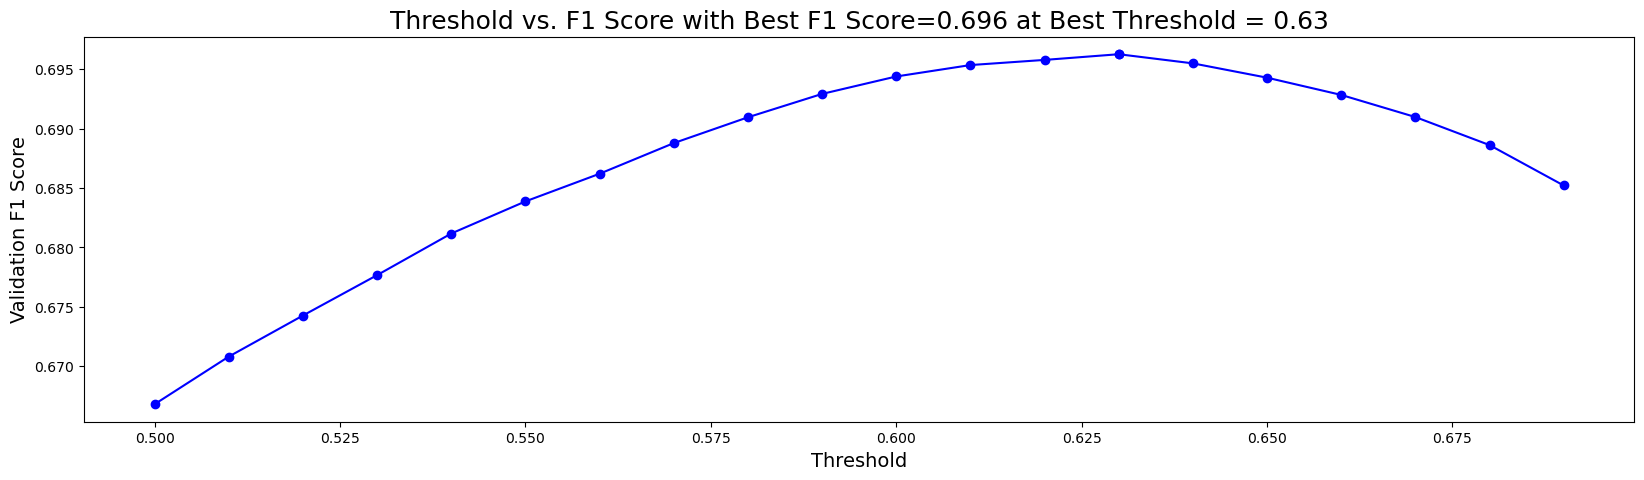

In [130]:
# Plot: Threshold vs. F1 Score
plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, '-o', color = 'blue')
plt.scatter([best_threshold], [best_socre], color='blue')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score", size=14)
plt.title(f'Threshold vs. F1 Score with Best F1 Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

In [131]:
# F1 Score
print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =', m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average='macro')
print('==> Overall F1 =', m)

When using optimal threshold = 0.63...
Q0: F1 = 0.6723018400346581
Q1: F1 = 0.502302229779896
Q2: F1 = 0.5151838751235016
Q3: F1 = 0.6744685010870765
Q4: F1 = 0.6282929719487301
Q5: F1 = 0.6427384011519552
Q6: F1 = 0.6247353458577737
Q7: F1 = 0.5616148492482471
Q8: F1 = 0.6309112732449327
Q9: F1 = 0.570764606824912
Q10: F1 = 0.6117675938733562
Q11: F1 = 0.5175337619874181
Q12: F1 = 0.457699120976993
Q13: F1 = 0.6391136360021525
Q14: F1 = 0.5899040141375047
Q15: F1 = 0.496124068139156
Q16: F1 = 0.5573616351018225
Q17: F1 = 0.4931781612914613
==> Overall F1 = 0.696269064402177


In [132]:
import pickle
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()